# Building analysis with ETABS

## Connect to ETABS

In [2]:
import sys
sys.path.append('C:\\Users\\Equipo 32\\Documents\\GitHub\\ETABS-Ninja')

from etabsninja.interface import connect_to_etabs, test_etabs_connection
# Run this one time and that's it
SapModel,EtabsObject = connect_to_etabs()
test_etabs_connection()

ETABS connection test successful


## Elastic Analysis

Drift X is 0.001257 < 0.0025. Verifies. 50% DCR
Drift Y is 0.001544 < 0.0025. Verifies. 62% DCR
Drift X is 0.001257 < 0.0025. Verifies. 50% DCR
Drift Y is 0.001544 < 0.0025. Verifies. 62% DCR
('Story', 'Diaphragm', 'UX', 'UY', 'RZ', 'Point', 'X', 'Y', 'Z')
     Story Diaphragm          UX          UY         RZ Point        X    Y  \
0  Story10        D1    0.053684  -1.731E-11          0   857  428.394  432   
1  Story10        D1  -7.402E-11     0.58722   0.002081   857  428.394  432   
2  Story10        D1    0.040263    0.048181   0.000197   857  428.394  432   
3  Story10        D1    0.040263   -0.048181  -0.000197   857  428.394  432   
4  Story10        D1  -7.776E-11     0.59539   0.002195   857  428.394  432   

      Z  
0  1224  
1  1224  
2  1224  
3  1224  
4  1224  


KeyError: 'Direction'

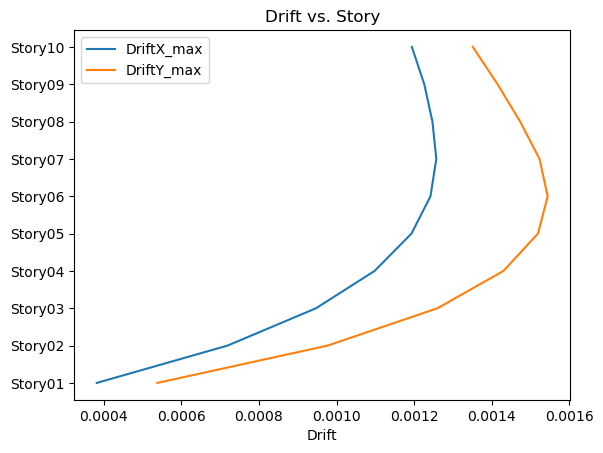

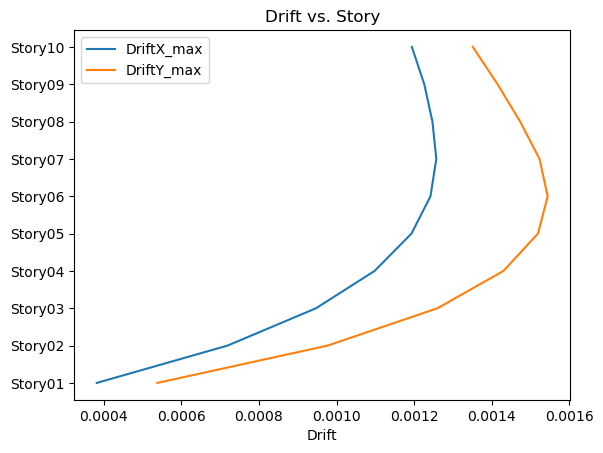

: 

In [3]:
import importlib
imported_module = importlib.import_module("etabsninja.get_functions")
importlib.reload(imported_module)
from etabsninja.get_functions import *

story_data = get_story_data(SapModel)
# frames = get_all_frames(SapModel)
# points = get_all_points(SapModel, inc_restraint=False)
LoadCaseList = ["W Service"]
story_drifts = get_StoryDriftsForStories(SapModel,LoadCaseList,0.0025)
story_drifts = get_StoryDriftsForJoints(SapModel,LoadCaseList,"Nodos",0.0025)

# print(SapModel.DatabaseTables.GetAvailableTables())
exit(0)
#Get the data using API
SapModel.DatabaseTables.SetLoadCasesSelectedForDisplay(LoadCaseList)
TableFields = SapModel.DatabaseTables.GetAllFieldsInTable('Diaphragm Center Of Mass Displacements')[3]
CMDisplacements = SapModel.DatabaseTables.GetTableForDisplayArray('Diaphragm Center Of Mass Displacements', TableFields, "All")[4]
TableFieldsIncluded = SapModel.DatabaseTables.GetTableForDisplayArray('Diaphragm Center Of Mass Displacements', TableFields, "All")[2]
print(TableFieldsIncluded)
# Determine the number of columns
NumColumns = len(TableFieldsIncluded)

# Reshape the JointDrifts list into a 2D array with the appropriate dimensions
CMDisplacements_array = [CMDisplacements[i:i+NumColumns] for i in range(0, len(CMDisplacements), NumColumns)]
# Create the DataFrame using the reshaped array and the column names
df = pd.DataFrame(CMDisplacements_array, columns=TableFieldsIncluded)
print(df.head())
# Convert 'UX' and 'UY column to float
df[['UX','UY']] = df[['UX','UY']].astype(float)

# Group the DataFrame by 'Story' and calculate the minimum and maximum values of 'Drift'
df = df.groupby(['Story','Direction'])[['Drift']].agg(['max'])

# Flatten the column names by joining them with an underscore
df.columns = ['_'.join(col).strip() for col in df.columns.values]

# Reset the index to make 'Story' a regular column
df.reset_index(inplace=True)

# Pivot the DataFrame to create separate columns for 'DriftX' and 'DriftY' values
df = df.pivot(index='Story', columns='Direction', values='Drift_max').reset_index()

# Rename the columns
df.columns = ['Story', 'DriftX_max', 'DriftY_max']

# Sort the DataFrame by 'Story' column in alphabetical order
df = df.sort_values('Story', ascending=True)